Архитектура модели: https://github.com/braindotai/Facial-Landmarks-Detection-Pytorch/blob/master/Face%20Landmark%20Detection.ipynb

Видео с разработкой похожего проекта: https://yandex.ru/video/preview/?text=pytorch%20face%20landmark%20detector%20train&path=wizard&parent-reqid=1639489153223239-15820144156074927158-sas3-0841-245-sas-l7-balancer-8080-BAL-2582&wiz_type=vital&filmId=11724147734491295100

# Загрузка датасета

In [ ]:
!wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
!tar -xzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
!rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

Проблема 1: некоторые координаты bbox (top или left) могут иметь отрицательное значение. Это ошибка разметки. Исправляем взятием числа по модулю.
Проблема 2: на многих изображениях координаты ключевых точек выходят за пределы координат bbox. Это ошибки разметки, которые сокращают объем полезной информации при выделении лица на изображении. Решение - увеличить границы bbox до максимальных значений координат ключевых точек.

# Подключение библиотек

In [2]:
import os
import imageio
import numpy as np
from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import PIL
import albumentations as A
import random
from albumentations.pytorch import ToTensorV2
import torchvision.models as models
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
from typing import List

# Используемые функции

In [3]:
def create_pandas_df(dataset_addr: str, train: bool = True) -> pd.DataFrame:
    '''Функция создания pd.DataFrame с информацией о локальных адресах изображений людей, bbox'ах лиц, координатах 
    ключевых точек на основе xml файлов
    Входные параметры:
    dataset_addr: str - директория датасета ibug_300W_large_face_landmark_dataset
    train: bool - флаг для создания тренировочного или тестового датафрейма
    Возвращаемые значения:
    data: pd.DataFrame - таблица с информацией о локальных адресах изображений людей, bbox'ах лиц, координатах 
    ключевых точек'''
    
    image_paths = []
    landmarks = []
    face_bboxes = []
    
    tree = ElementTree.parse(os.path.join(dataset_addr, f'labels_ibug_300W_{"train" if train else "test"}.xml'))
    root = tree.getroot() 
    
    for filename in root[2]:
        image_paths.append(os.path.join(dataset_addr, filename.attrib['file']))
        face_bbox = np.array(list(filename[0].attrib.values()), dtype=int)
        face_bboxes.append(face_bbox)
        image_landmarks = []
        
        for num in range(68):
            x_coordinate = int(filename[0][num].attrib['x'])
            y_coordinate = int(filename[0][num].attrib['y'])
            image_landmarks.append([x_coordinate, y_coordinate])
        landmarks.append(np.array(image_landmarks).astype('float32'))
    
    data = {}
    data['image_paths'] = image_paths
    # face_bboxes - массив из 4 значений top, left, width, height
    data['face_bboxes'] = face_bboxes
    # landmarks - массив из 68 пар значений координат ключевой точки (x, y)
    data['landmarks'] = landmarks
    data = pd.DataFrame.from_dict(data)
    
    return data

In [4]:
def visualize_image(dataframe: pd.DataFrame, index: int, crop_face: bool = False):
    '''Функция проверки правильности разметки исходных данных путем вывода исходного изображения на экран
    (или только изображения в рамках bbox) и отрисовки соответствующих ему ключевых точек
    Входные параметры:
    dataframe: pd.DataFrame - таблица с информацией о локальных адресах изображений людей, bbox'ах лиц, координатах 
    ключевых точек
    index: int - индекс записи в таблице
    crop_face: bool - флаг, выводить ли только изображене в рамках bbox'''
    
    image = dataframe['image_paths'][index]
    landmarks = dataframe['landmarks'][index]
    bbox = dataframe['face_bboxes'][index]
    top, left, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
    bottom = top + height
    right = left + width
    
    image = PIL.Image.open(image)
    image = np.array(image)
    
    if crop_face == True:
        # Часто область изображения, выделенная bbox, меньше области, охваченной ключевыми точками (ошибки разметки),
        # это приводит к потере полезной информации, поэтому нужно расширить границы bbox для таких изображений
        # до минимальных (максимальных координат ключевых точек)

        landmarks_min_x = np.min(landmarks[:, 0])
        landmarks_max_x = np.max(landmarks[:, 0])

        landmarks_min_y = np.min(landmarks[:, 1])
        landmarks_max_y = np.max(landmarks[:, 1])
        
        if(landmarks_min_y < top):
            top = landmarks_min_y
        
        if(landmarks_max_y > bottom):
            bottom = landmarks_max_y
        
        if(landmarks_min_x < left):
            left = landmarks_min_x
        
        if(landmarks_max_x > right):
            right = landmarks_max_x
        
        image = image[int(top): int(bottom), int(left): int(right)]
        landmarks = landmarks - np.array([[left, top]])

        
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 25, c = 'dodgerblue')
    plt.axis('off')
    plt.show()

In [18]:
def visualize_batch(images: torch.Tensor, landmarks: torch.Tensor, size: int = 14, 
                    shape: tuple = (6, 6), title: str = None, save: bool = None):
    '''Функция проверки правильной работы пайплайна предобработки данных перед подачей в нейронную сеть
    (с учетом аугментации) на основе сформированного батча путем вывода на экран изображений, находящихся в батче,
    и соответствующих им ключевых точек
    Входные параметры:
    images: torch.Tensor - батч изображений
    landmarks: torch.Tensor - батч координат ключевых точек
    size: int - размер фигуры для отрисовки изображений и ключевых точек
    shape: tuple - число ячеек по горизонтали и вертикали, в которых будут изображения
    title: str - заголовок
    save: bool - флаг сохранения'''
    
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images, landmarks):
        landmarks = landmarks.view(-1, 2)
        landmarks = landmarks.numpy()
        image = torch.permute(image, (1, 2, 0))
        ax.imshow(image)
        ax.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, c = 'dodgerblue')
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

# Используемые классы

In [6]:
# Описанные в данной ячейке классы используются для создания нейронной сети (архитектура XCeption), 
# решающей данную задачу

class DepthewiseSeperableConv2d(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, **kwargs):
        super(DepthewiseSeperableConv2d, self).__init__()

        self.depthwise = nn.Conv2d(input_channels, input_channels, kernel_size, groups = input_channels, bias = False, **kwargs)
        self.pointwise = nn.Conv2d(input_channels, output_channels, 1, bias = False)

        
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)

        return x


class EntryBlock(nn.Module):
    def __init__(self):
        super(EntryBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.conv3_residual = nn.Sequential(
            DepthewiseSeperableConv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(64, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride = 2, padding = 1),
        )

        self.conv3_direct = nn.Sequential(
            nn.Conv2d(64, 128, 1, stride = 2),
            nn.BatchNorm2d(128),
        )

        self.conv4_residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.conv4_direct = nn.Sequential(
            nn.Conv2d(128, 256, 1, stride = 2),
            nn.BatchNorm2d(256),
        )

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        residual = self.conv3_residual(x)
        direct = self.conv3_direct(x)
        x = residual + direct
        
        residual = self.conv4_residual(x)
        direct = self.conv4_direct(x)
        x = residual + direct

        return x


class MiddleBasicBlock(nn.Module):
    def __init__(self):
        super(MiddleBasicBlock, self).__init__()

        self.conv1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )
        self.conv3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256)
        )

        
    def forward(self, x):
        residual = self.conv1(x)
        residual = self.conv2(residual)
        residual = self.conv3(residual)

        return x + residual


class MiddleBlock(nn.Module):
    def __init__(self, num_blocks):
        super().__init__()

        self.block = nn.Sequential(*[MiddleBasicBlock() for _ in range(num_blocks)])

    def forward(self, x):
        x = self.block(x)

        return x


class ExitBlock(nn.Module):
    def __init__(self):
        super(ExitBlock, self).__init__()

        self.residual = nn.Sequential(
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(256, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )

        self.direct = nn.Sequential(
            nn.Conv2d(256, 512, 1, stride = 2),
            nn.BatchNorm2d(512)
        )

        self.conv = nn.Sequential(
            DepthewiseSeperableConv2d(512, 512, 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            DepthewiseSeperableConv2d(512, 1024, 3, padding = 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2)
        )

        self.dropout = nn.Dropout(0.3)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        
    def forward(self, x):
        direct = self.direct(x)
        residual = self.residual(x)
        x = direct + residual
        
        x = self.conv(x)
        x = self.avgpool(x)
        x = self.dropout(x)

        return x


class XceptionNet(nn.Module):
    def __init__(self, num_middle_blocks = 6):
        super(XceptionNet, self).__init__()

        self.entry_block = EntryBlock()
        self.middel_block = MiddleBlock(num_middle_blocks)
        self.exit_block = ExitBlock()

        self.fc = nn.Linear(1024, 136)

        
    def forward(self, x):
        x = self.entry_block(x)
        x = self.middel_block(x)
        x = self.exit_block(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc(x)

        return x

In [7]:
# Постороение альтернативной модели на основе mobilenet_v3_small
class MobileLandmarkNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        # Заменяем последние 2 полносвязных слоя на имеющие нужную размерность
        self.backbone.classifier[0] = nn.Linear(576, 256)
        self.backbone.classifier[3] = nn.Linear(256, 136)

        
    def get_layers_names(self):
         return dict(self.backbone.named_modules())

        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [8]:
class LandmarksDataset(Dataset):
    '''Класс для создания датасетов'''
    
    def __init__(self, dataframe: pd.DataFrame, device: str, transform: object):
        '''Входные параметры:
        dataframe: pd.DataFrame - датафрейм с адресами изображений, координатами bbox'ов и ключевых точек
        device: str - имя устройства, на котором будут обрабатываться данные
        transform: object - список преобразований, которым будут подвергнуты изображения и маски'''
        
        self.image_paths = dataframe['image_paths']
        self.landmarks = dataframe['landmarks']
        self.face_bboxes = dataframe['face_bboxes']
        self.transform = transform
        self.data_len = len(dataframe.index)
        self.device = device
        
    def __getitem__(self, index: int):
        '''Входные параметры:
        index: int - индекс для обращения к элементам датафрейма dataframe
        Возвращаемые значения:
        Tuple[torch.Tensor] - кортеж из тензорного представления изображения лица и координат
        ключевых точек'''
        
        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('float')/255.0
        
        # Часто область изображения, выделенная bbox, меньше области, охваченной ключевыми точками (ошибки разметки),
        # это приводит к потере полезной информации, поэтому нужно расширить границы bbox для таких изображений
        # до минимальных (максимальных координат ключевых точек)
        bbox = self.face_bboxes[index]
        top, left, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
        bottom = top + height
        right = left + width
        
        landmarks_min_x = np.min(self.landmarks[index][:, 0])
        landmarks_max_x = np.max(self.landmarks[index][:, 0])

        landmarks_min_y = np.min(self.landmarks[index][:, 1])
        landmarks_max_y = np.max(self.landmarks[index][:, 1])
        
        if(landmarks_min_y < top):
            top = landmarks_min_y
        
        if(landmarks_max_y > bottom):
            bottom = landmarks_max_y
        
        if(landmarks_min_x < left):
            left = landmarks_min_x
        
        if(landmarks_max_x > right):
            right = landmarks_max_x
        
        # Нельзя, чтобы координаты ключевой точки лежали на границе изображения,
        # иначе albumintation не будет работать, поэтому используем np.pad
        # (увеличиваем пространственные измерения на 1 с каждого края, канальные не трогаем)
        face_image = image[int(top): int(bottom), int(left): int(right)]
        face_image = np.pad(face_image, ((1,1),(1,1),(0,0)), mode='edge')
        
        landmarks = self.landmarks[index] - np.array([[left, top]])

        transformed = self.transform(image=face_image, keypoints=landmarks)
        transformed_image = transformed['image'].to(self.device).float()
        transformed_landmarks = transformed['keypoints']
        # transformed координаты ключевых точек не преобразует в тензор, поэтому сделаем вручную
        transformed_landmarks = torch.FloatTensor(transformed_landmarks).to(self.device).float()
        transformed_landmarks = transformed_landmarks.view(-1)

        return transformed_image, transformed_landmarks

    def __len__(self):
        return self.data_len

In [9]:
class ModelWrapper(nn.Module):
    '''Класс, реализующий функционал для работы с нейронной сетью для распознавания ключевых точек лица'''
    
    def __init__(self, model: object):
        '''Конструктор класса
        Входные параметры:
        model: object - последовательность слоев или модель, через которую будут проходить данные'''
        
        super(ModelWrapper, self).__init__()
        self.model = model

        
    def forward(self, input_data):
        '''Метод прямого прохода через объект класса
        Входные параметры:
        input_data: torch.Tensor - тензорное представление изображения лица
        Возвращаемые значения: 
        output_data: torch.Tensor - предсказанные координаты ключевых точек в тензорном формате'''
        
        output_data = self.model(input_data)
        return output_data
    
    
    def fit(self, criterion: object, metric: object, optimizer: object, scheduler: object,
                  train_data_loader: DataLoader, valid_data_loader: DataLoader=None, 
                  epochs: int=1, verbose: int=5):
        '''Метод для обучения модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        optimizer: object - оптимизатор
        scheduler: object - объект для изменения lr в ходе обучения
        train_data_loader: DataLoader - загрузчик данных для обучения
        valid_data_loader: DataLoader - загрузчик данных для валидации
        epochs: int - количество эпох обучения
        verbose: int - вывод информации через каждые verbose итераций
        Возвращаемые значения:
        result: dict - словарь со значениями loss при тренировке, валидации и метрики при валидации 
        для каждой эпохи'''
        
        self.optimizer = optimizer
        epoch_train_losses = []
        epoch_valid_losses = []
        epoch_valid_metrics = []
        result = {}
        
        for epoch in range(epochs):
            self.model.train()
            time1 = time.time()
            running_loss = 0.0
            train_losses = []
            
            for batch_idx, data in enumerate(train_data_loader):

                #data = Variable(data[0])
                inputs = data[0]
                target = data[1]
                optimizer.zero_grad()
                outputs = self.model(inputs)

                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                train_losses.append(loss.item())
                if (batch_idx+1) % verbose == 0:
                    print(f'Train Epoch: {epoch+1}, Loss: {(running_loss/verbose):.6f}, ', end="")
                    print(f'Learning rate: {scheduler.get_last_lr()[0]}')
                    time2 = time.time()
                    print(f'Spended time for {verbose} batches ({int((verbose*data[0].shape[0]))} images', end="") 
                    print(f': {(time2-time1):.6f} sec')
                    
                    time1 = time.time()
                    running_loss = 0.0

            train_loss = np.mean(train_losses)
            self.visualize_batch(train_data_loader, size=14)
            scheduler.step()
            
            if valid_data_loader != None:
                valid_result = self.valid(criterion, metric, valid_data_loader)
                valid_loss = valid_result['valid_loss']
                valid_metric = valid_result['valid_metric']
            
                print('='*80)
                print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}, valid loss: {(valid_loss):.6f}, ', end="")
                print(f'valid metric: {(valid_metric):.6f}')
                print('='*80)
            else:
                print('='*80)
                print(f'Epoch {epoch+1}, train loss: {(train_loss):.6f}')
                print('='*80)
                valid_loss = None
                valid_metric = None
            
            epoch_train_losses.append(train_loss)
            epoch_valid_losses.append(valid_loss)
            epoch_valid_metrics.append(valid_metric)
        
        result['epoch_train_losses'] = epoch_train_losses
        result['epoch_valid_losses'] = epoch_valid_losses
        result['epoch_valid_metrics'] = epoch_valid_metrics
        
        return result
    
    
    def valid(self, criterion: object, metric: object, valid_data_loader: DataLoader):
        '''Метод для валидации модели
        Входные параметры:
        criterion: object - объект для вычисления loss
        metric: object - объект для вычисления метрики качества
        valid_data_loader: DataLoader - загрузчик данных для валидации
        Возвращаемые значения:
        result: dict - словарь со значениями loss и метрики при валидации'''
        
        self.model.eval()
        valid_metrics = []
        valid_losses = []
        result = {}
        for batch_idx, data in enumerate(valid_data_loader):
            inputs = data[0]
            target = data[1]
            outputs = self.model(inputs)        
            loss = criterion(outputs, target)
            valid_losses.append(loss.item())
                    
            metric_value = metric(outputs, target)
            valid_metrics.append(metric_value.item())
                
        valid_loss    = np.mean(valid_losses)
        valid_metric  = np.mean(valid_metrics, axis=0)
        result['valid_loss'] = valid_loss
        result['valid_metric'] = valid_metric
        self.model.train()
        
        return result

    
    def visualize_batch(self, data_loader: DataLoader, size: int = 14, shape: int = (4, 4), 
                        title: str = None, save: bool = None):
        '''Метод визуализации качества работы модели с использованием загрузчика данных 
        Входные параметры:
        data_loader: DataLoader - загрузчик данных для получения изображений
        size: int - размер фигуры для отрисовки изображений и ключевых точек
        shape: tuple - число ячеек по горизонтали и вертикали, в которых будут изображения
        title: str - заголовок
        save: bool - флаг сохранения'''
        
        self.model.eval()
        iterator = iter(data_loader)
        batch = iterator.next()
        inputs = batch[0]
        outputs = self.model(inputs)
        self.model.train()
        #shape = (int(data.shape[0]/2), int(data.shape[0]/2))
        fig = plt.figure(figsize = (size, size))
        grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
        for ax, image, landmarks in zip(grid, inputs, outputs):
            landmarks = landmarks.view(-1, 2)
            landmarks = landmarks.detach().cpu().numpy()
            image = torch.permute(image, (1, 2, 0)).cpu()
            ax.imshow(image)
            ax.scatter(landmarks[:, 0], landmarks[:, 1], s = 10, c = 'dodgerblue')
            ax.axis('off')

        if title:
            print(title)
        if save:
            plt.savefig(save)
        plt.show()
    
    
    def save(self, path_to_save: str = './landmark_model.pth'):
        '''Метод сохранения весов модели
        Входные параметры:
        path_to_save: str - директория для сохранения состояния модели'''
        
        torch.save(self.model.state_dict(), path_to_save)
    
    
    def trace_save(self, path_to_save: str = './landmark_model.pth'):
        '''Метод сохранения модели через torchscript
        Входные параметры:
        path_to_save: str - директория для сохранения модели'''
        
        example_forward_input = torch.rand(1, 3, 128, 128).to('cpu')
        if next(self.model.parameters()).is_cuda:
            example_forward_input= example_forward_input.to('cuda:0')
            
        traced_model = torch.jit.trace((self.model).eval(), example_forward_input)
        torch.jit.save(traced_model, path_to_save)


    def load(self, path_to_model: str = './landmark_model.pth'):
        '''Метод загрузки весов модели
        Входные параметры:
        path_to_model: str - директория с сохраненными весами модели'''
        
        self.model.load_state_dict(torch.load(path_to_model))

# Проверка правильности разметки данных

In [10]:
dataset_addr = '/home/dima/datasets/ibug_300W_large_face_landmark_dataset'

train_df = create_pandas_df(dataset_addr, train=True)
test_df = create_pandas_df(dataset_addr, train=False)
train_df.head()

,image_paths,face_bboxes,landmarks
0,/home/dima/datasets/ibug_300W_large_face_landm...,"[78, 74, 138, 140]","[[55.0, 141.0], [59.0, 161.0], [66.0, 182.0], ..."
1,/home/dima/datasets/ibug_300W_large_face_landm...,"[130, 31, 447, 447]","[[107.0, 150.0], [99.0, 238.0], [97.0, 314.0],..."
2,/home/dima/datasets/ibug_300W_large_face_landm...,"[378, 279, 446, 447]","[[260.0, 492.0], [269.0, 564.0], [276.0, 634.0..."
3,/home/dima/datasets/ibug_300W_large_face_landm...,"[247, 878, 259, 259]","[[925.0, 341.0], [925.0, 369.0], [926.0, 399.0..."
4,/home/dima/datasets/ibug_300W_large_face_landm...,"[693, 940, 1110, 1111]","[[1060.0, 1025.0], [1081.0, 1180.0], [1121.0, ..."


In [156]:
print(f'Images for train: {train_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 6666, images for test: 1008


In [1]:
for i in range(1000):
    visualize_image(train_df, i, crop_face=True)

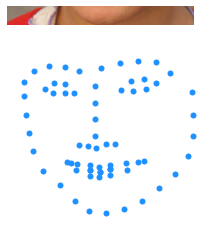

In [119]:
visualize_image(train_df, 49, crop_face=True)

In [217]:
# Ошибка если запустить
#visualize_image(train_df, 56, crop_face=True)

In [120]:
train_df['face_bboxes'][49]

array([-293,   77, 1110, 1234])

In [121]:
train_df['face_bboxes'][56]

array([-57,  67, 373, 414])

Заметка: в процессе исследования данных обнаружено, что для некоторых изображений есть отрицательные значения в массивах face_bboxes, что является ошибкой. Исправим это. Заменим отрицательные значения на положительные и проверим правильность разметки.

In [11]:
train_df['face_bboxes'] = train_df['face_bboxes'].apply(lambda x: np.abs(x))
test_df['face_bboxes'] = test_df['face_bboxes'].apply(lambda x: np.abs(x))

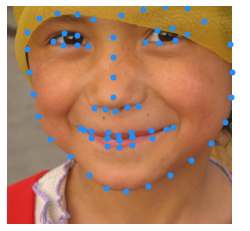

In [12]:
visualize_image(train_df, 49, crop_face=True)

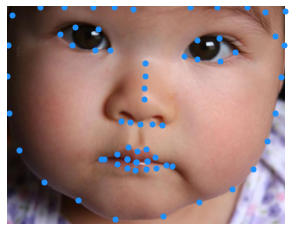

In [13]:
visualize_image(train_df, 56, crop_face=True)

Вывод: в процессе разметки в bbox появились минусы перед числовыми значениями, поэтому нужно брать модуль от значений в face_bboxes

# Создание проверочного загрузчика данных

In [14]:
# remove_invisible = False - делать обязательно, иначе аугментатор может удалить некоторые ключевые точки
# во время трансформации, и батч не сможет сформироваться

transform_train = A.Compose([
    A.Resize(128, 128),
    A.Rotate(limit=20, interpolation=1, border_mode=4, value=None, always_apply=True, p=1),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False, angle_in_degrees=True))

In [15]:
train_dataset = LandmarksDataset(train_df, 'cpu', transform_train)
train_data_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)

# Проверка правильности пайплайна обработки данных (с учетом аугментации)

In [19]:
train_iterator = iter(train_data_loader)
batch = train_iterator.next()
print(f'Batch data shape: {batch[0].shape}')
print(f'Batch target shape: {batch[1].shape}')
print(f'Min value in batch data: {torch.min(batch[0]).item()}')
print(f'Max value in batch data: {torch.max(batch[0]).item()}')

Batch data shape: torch.Size([36, 3, 128, 128])
Batch target shape: torch.Size([36, 136])
Min value in batch data: 0.0
Max value in batch data: 1.0


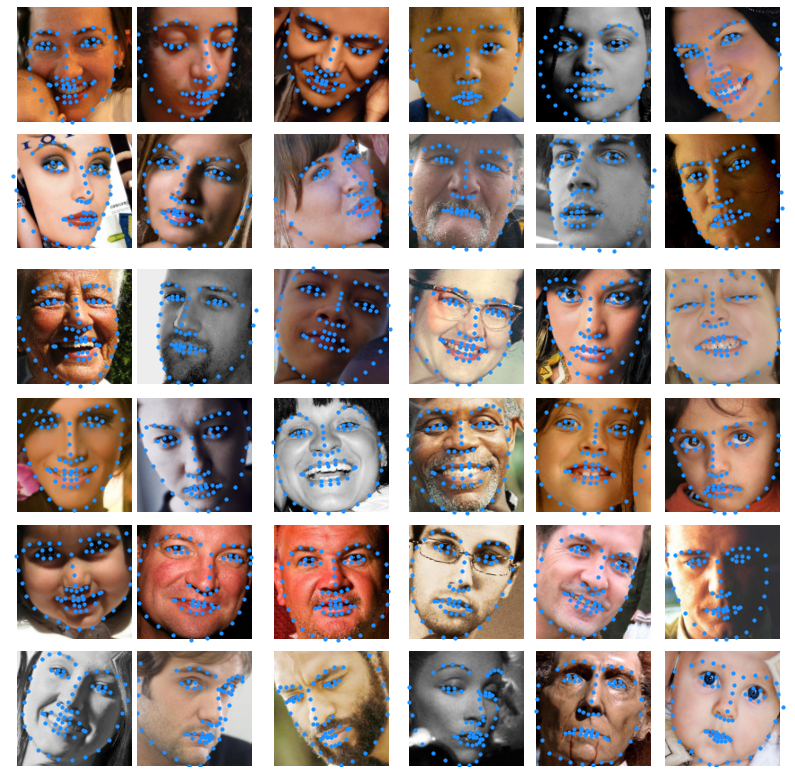

In [20]:
batch = train_iterator.next()
visualize_batch(batch[0], batch[1])

# Обучение модели

In [21]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [10]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [11]:
!nvidia-smi

Fri Dec 17 10:15:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   39C    P8    15W / 170W |    360MiB / 12045MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
learning_rate = 0.003
num_epochs = 30
batch_size = 16

In [26]:
dataset_addr = '/home/dima/datasets/ibug_300W_large_face_landmark_dataset'
train_df = create_pandas_df(dataset_addr, train=True)
test_df = create_pandas_df(dataset_addr, train=False)

train_df['face_bboxes'] = train_df['face_bboxes'].apply(lambda x: np.abs(x))
test_df['face_bboxes'] = test_df['face_bboxes'].apply(lambda x: np.abs(x))

train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

transform_train = A.Compose([
    A.Resize(128, 128),
    A.Rotate(limit=20, interpolation=1, border_mode=4, value=None, always_apply=True, p=1),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False, angle_in_degrees=True))

transform_test = A.Compose([
    A.Resize(128, 128),
    ToTensorV2()
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False, angle_in_degrees=True))

train_dataset = LandmarksDataset(train_df, device, transform_train)
valid_dataset = LandmarksDataset(valid_df, device, transform_test)
test_dataset = LandmarksDataset(test_df, device, transform_test)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f'Images for train: {train_df.shape[0]}, images for validation: {valid_df.shape[0]}, images for test: {test_df.shape[0]}')

Images for train: 5999, images for validation: 667, images for test: 1008


In [298]:
#model = MobileLandmarkNet().to(device)
model = XceptionNet().to(device)

model_wrapper = ModelWrapper(model=model)
summary(model_wrapper.model, input_size=(32, 3, 128, 128))

Layer (type:depth-idx)                                       Output Shape              Param #
XceptionNet                                                  --                        --
├─EntryBlock: 1-1                                            [32, 256, 32, 32]         --
│    └─Sequential: 2-1                                       [32, 32, 128, 128]        --
│    │    └─Conv2d: 3-1                                      [32, 32, 128, 128]        864
│    │    └─BatchNorm2d: 3-2                                 [32, 32, 128, 128]        64
│    │    └─LeakyReLU: 3-3                                   [32, 32, 128, 128]        --
│    └─Sequential: 2-2                                       [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-4                                      [32, 64, 128, 128]        18,432
│    │    └─BatchNorm2d: 3-5                                 [32, 64, 128, 128]        128
│    │    └─LeakyReLU: 3-6                                   [32, 64, 128, 128]        --

In [299]:
optimizer = torch.optim.Adam(model_wrapper.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = nn.MSELoss()
metric = loss = nn.MSELoss()

In [1]:
result_train = model_wrapper.fit(criterion,
             metric,
             optimizer,
             scheduler,
             train_data_loader,
             valid_data_loader,
             epochs=10,
             verbose=10)

In [ ]:
# XceptionNet
# batch 16
# 128 128
# lr 0.001
# gamma = 0.8
# 10 эпох 21 val 22 test
# 20 эпох 16 val 17 test
# 30 эпох 15.5 val 16.8 test

# Mobilenet v3 small
# batch 16
# 128 128
# lr 0.001
# gamma = 0.8
# 10 эпох val 27.6 test 28.3
# 20 эпох val 19.9 test 20.6
# 30 эпох val test

# Mobilenet v3 small
# batch 16
# 128 128
# lr 0.002
# gamma = 0.9
# 10 эпох val 20.29 test 20.75
# 20 эпох val  test 
# 30 эпох val  test

# XceptionNet
# batch 16
# 128 128
# lr 0.003
# gamma = 0.95
# 10 эпох val 21.6 test 22.8
# 20 эпох val 9.2 test 9.8
# 30 эпох val 8.2 test 8.5
# 40 эпох val 7.1 test 7.4
# 50 эпох val 6.8 test 7.06

In [316]:
result_valid = model_wrapper.valid(criterion, metric, valid_data_loader)
result_valid

{'valid_loss': 6.819057771137783, 'valid_metric': 6.819057771137783}

In [317]:
result_test = model_wrapper.valid(criterion, metric, test_data_loader)
result_test

{'valid_loss': 7.0641648731534445, 'valid_metric': 7.0641648731534445}

In [318]:
model_wrapper.save(path_to_save='./landmark_detection_xception_50ep_128_lr0.003_gamma0.95')

In [22]:
model = XceptionNet().to(device)
model_wrapper = ModelWrapper(model=model)
model_wrapper.load(path_to_model = './landmark_detection_xception_50ep_128_lr0.003_gamma0.95')

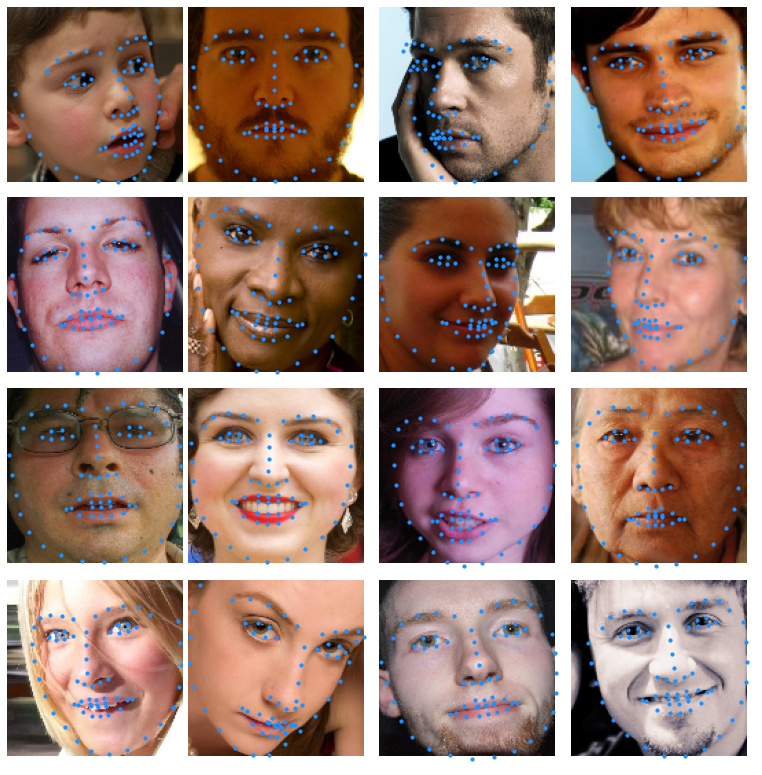

In [27]:
model_wrapper.visualize_batch(valid_data_loader, size=14)

In [26]:
if os.path.isdir('progress'):
    !rm -rf progress
os.mkdir('progress')

In [ ]:
    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        torch.save(model.state_dict(), 'model.pt')